In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv("../data/candy_production.csv", index_col=0)
data.head()

,IPG3113N
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [3]:
data.index = pd.to_datetime(data.index)
data.index.freq = 'MS'  # Set frequency to monthly start
data.columns = ["Product"]
data.head()

,Product
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [4]:
time_series = data[data.index.year >=int(1972)]
time_series.head()

,Product
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [5]:
time_series.tail()

,Product
observation_date,
2017-04-01,107.4288
2017-05-01,101.9209
2017-06-01,104.2022
2017-07-01,102.5861
2017-08-01,114.0613


In [6]:
# Check pause with ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - the series is stationary")
    else:
        print("Fail to reject the null hypothesis - the series is non-stationary")

ADF Statistic: -1.887049811225274
p-value: 0.3381775973004322
Fail to reject the null hypothesis - the series is non-stationary


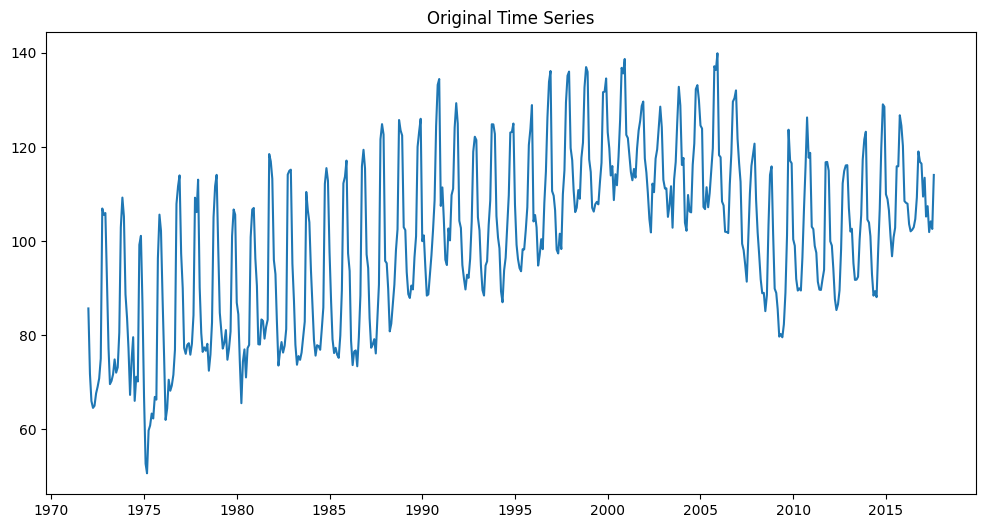

In [8]:
adf_test(time_series)

plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title("Original Time Series")
plt.show()

ADF Statistic: -6.11951150471579
p-value: 8.925584203568469e-08
Reject the null hypothesis - the series is stationary


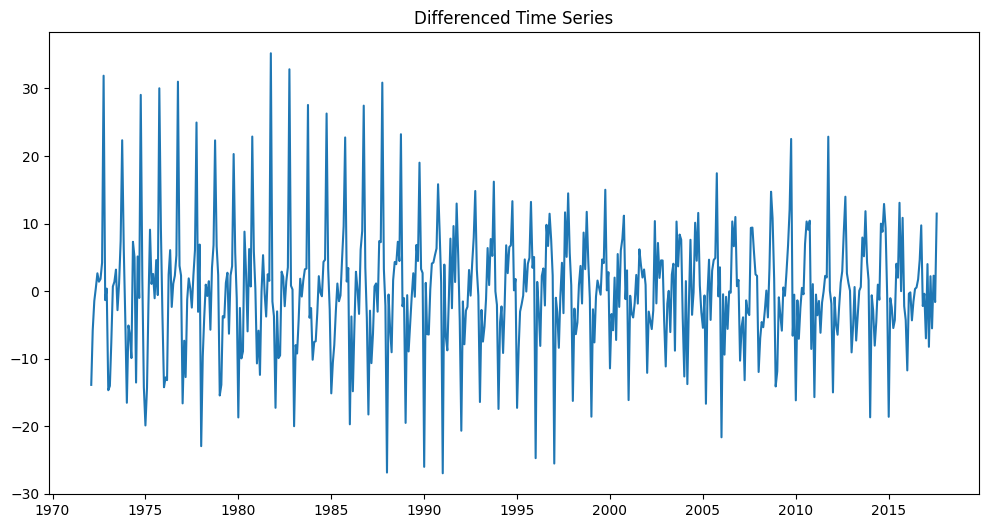

In [9]:
# Differencing the series first time
diff_series = time_series.diff(1).dropna()

# Check pause with ADF test after differencing
adf_test(diff_series)

plt.figure(figsize=(12, 6))
plt.plot(diff_series)
plt.title("Differenced Time Series")
plt.show()

NameError: name 'plot' is not defined

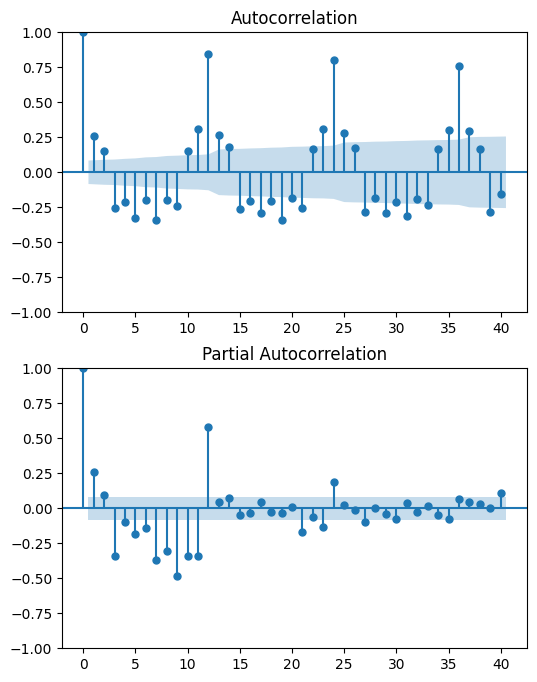

In [11]:
# Chart ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
plot_acf(diff_series, lags=40, ax=ax[0], alpha=0.05)
plot_pacf(diff_series, lags=40, ax=ax[1], alpha=0.05)
plot.show()

In [12]:
train_size = int(0.85*time_series.size)
train = time_series[:train_size]
test = time_series[train_size:]

In [13]:
p, d, q = 3, 1, 5

# fit ARIMA model
model = sm.tsa.ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Product   No. Observations:                  465
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -1479.600
Date:                Wed, 28 May 2025   AIC                           2977.200
Time:                        12:34:27   BIC                           3014.459
Sample:                    01-01-1972   HQIC                          2991.867
                         - 09-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7342      0.003    251.960      0.000       0.728       0.740
ar.L2          0.7271      0.005    136.798      0.000       0.717       0.737
ar.L3         -0.9961      0.003   -321.829      0.0

In [14]:
forecast = pd.DataFrame(model_fit.forecast(steps=int(test.size)))
forecast.head()

,predicted_mean
2010-10-01,118.812134
2010-11-01,114.262735
2010-12-01,113.073101
2011-01-01,106.364053
2011-02-01,101.330181


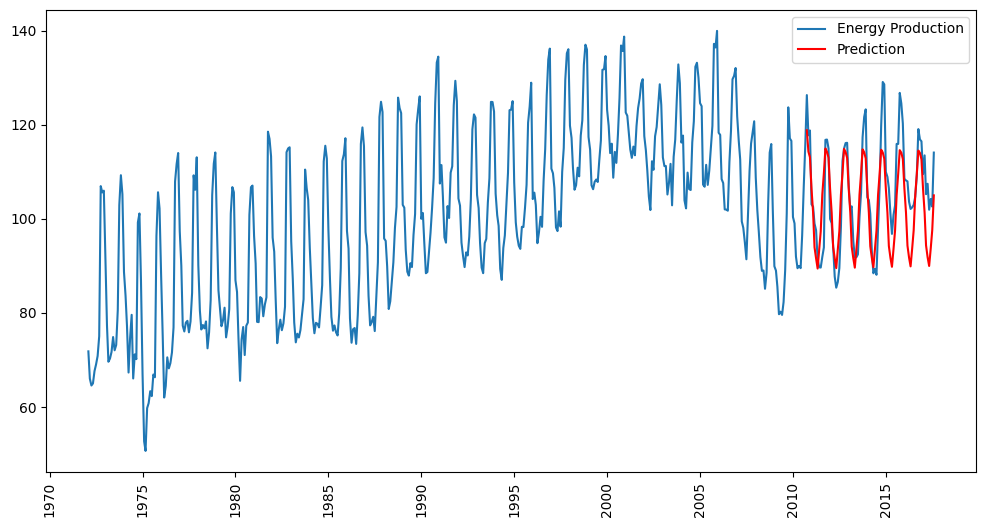

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(time_series.iloc[1:], label="Energy Production")
plt.plot(forecast, label="Prediction", color='red')
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

In [17]:
# Evaluate test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 53.894533222746375
Mean Absolute Error: 6.064230071863983


## Use Sarimax model

<Figure size 1200x800 with 0 Axes>

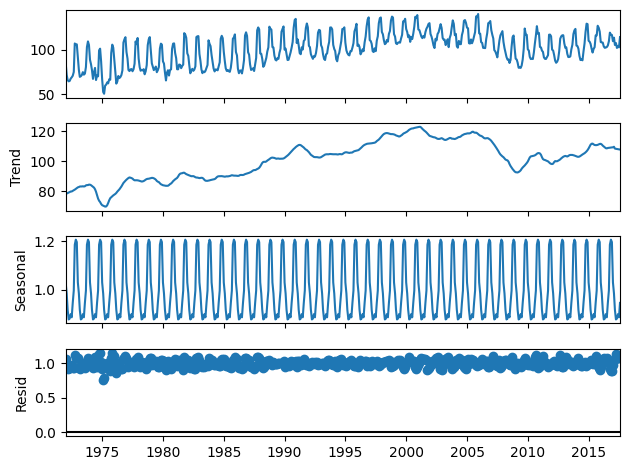

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12, 8))
result = seasonal_decompose(time_series, model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.show()

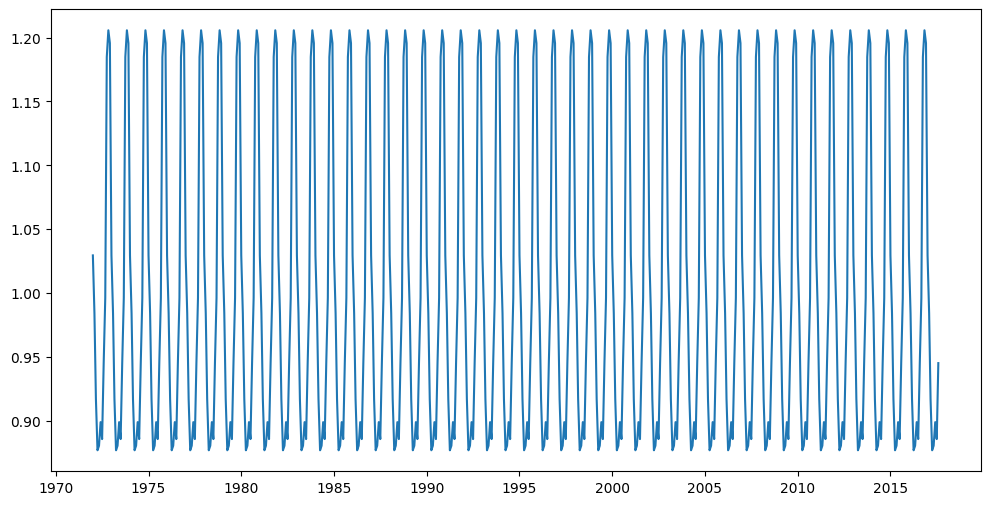

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(result.seasonal)

In [22]:
seasonal_data = time_series.diff(12).dropna()

adf_test(seasonal_data)

ADF Statistic: -4.989819790366835
p-value: 2.324609557691987e-05
Reject the null hypothesis - the series is stationary


## Choose D = 0 or D = 1 and find P, Q

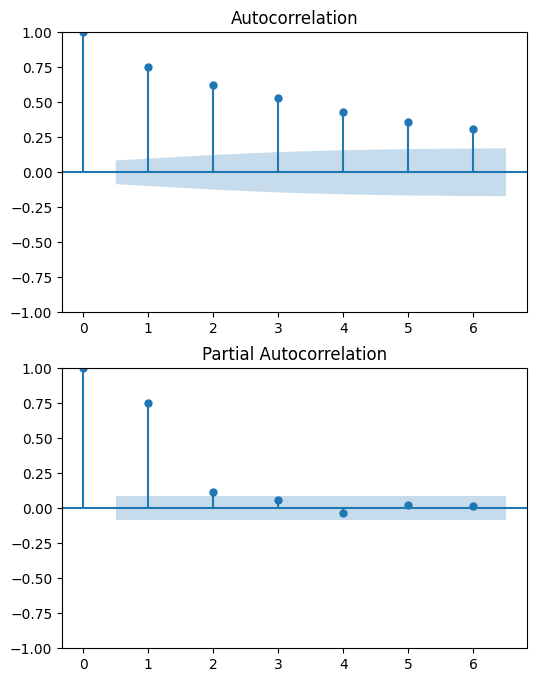

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
plot_acf(seasonal_data, lags=6, ax=ax[0], alpha=0.05)
plot_pacf(seasonal_data, lags=6, ax=ax[1], alpha=0.05)
plt.show()

In [25]:
model = sm.tsa.ARIMA(train, order=(3, 1, 5), seasonal_order=(2,1,0,12))
model_fit_sa = model.fit()
print(model_fit_sa.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Product   No. Observations:                  465
Model:             ARIMA(3, 1, 5)x(2, 1, [], 12)   Log Likelihood               -1230.013
Date:                           Wed, 28 May 2025   AIC                           2482.027
Time:                                   12:42:03   BIC                           2527.277
Sample:                               01-01-1972   HQIC                          2499.859
                                    - 09-01-2010                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2227      0.041     -5.428      0.000      -0.303      -0.142
ar.L2          0.0707      0.047      1.514

In [26]:
forecast_sa = pd.DataFrame(model_fit_sa.forecast(steps=int(test.size)))

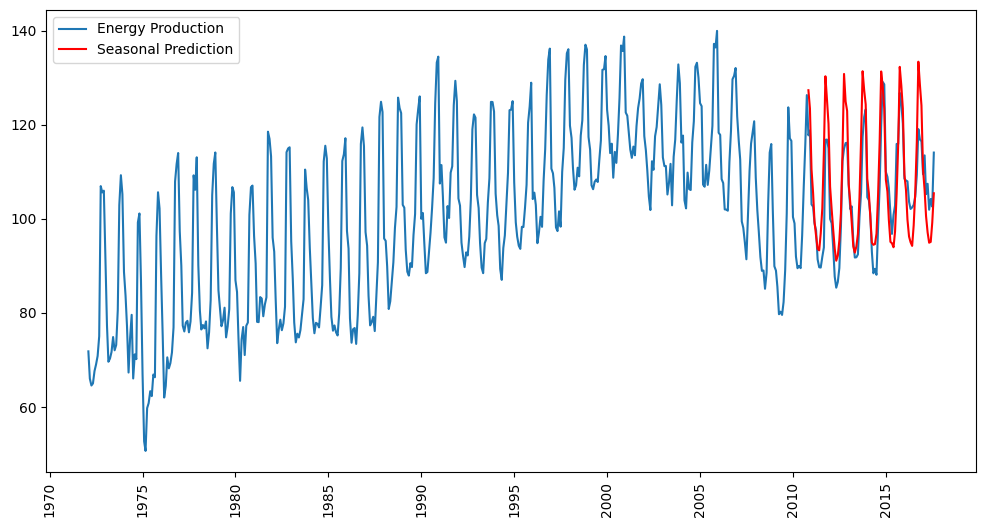

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(time_series.iloc[1:], label="Energy Production")
plt.plot(forecast_sa.iloc[1:], label="Seasonal Prediction", color='red')
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

In [28]:
# Evaluate test set for seasonal model
mse_sa = mean_squared_error(test, forecast_sa)
mae_sa = mean_absolute_error(test, forecast_sa)
print(f'Seasonal Mean Squared Error: {mse_sa}')
print(f'Seasonal Mean Absolute Error: {mae_sa}')

Seasonal Mean Squared Error: 48.165275901693796
Seasonal Mean Absolute Error: 5.706374031742485


## Use auto arima

In [29]:
from pmdarima import auto_arima

In [31]:
auto_model = auto_arima(train, max_p=12, max_q=12, m=12, d= 1, 
                        start_P=1, seasonal= True, D=1,trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2487.771, Time=1.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2654.043, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2574.372, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2499.448, Time=0.22 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=2494.461, Time=0.68 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=2557.191, Time=0.31 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=2486.504, Time=2.90 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=2525.737, Time=0.81 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=2484.013, Time=3.96 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=2487.679, Time=2.75 sec
 ARIMA(1,1,2)(2,1,2)[12]             : AIC=2483.654, Time=2.95 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=2486.510, Time=1.96 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=2485.460, Time=1.51 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=2486.193, Time=0.75 sec
 ARIMA(0,1,2)(2,1,2

In [32]:
auto_model.fit(train)

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [33]:
forecast_auto = pd.DataFrame(auto_model.predict(n_periods=int(test.size)))

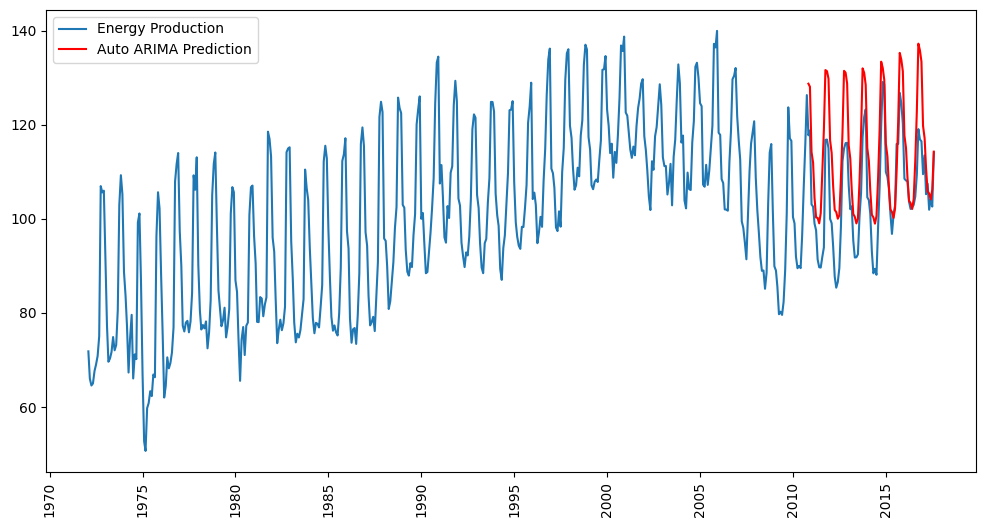

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(time_series.iloc[1:], label="Energy Production")
plt.plot(forecast_auto.iloc[1:], label="Auto ARIMA Prediction", color='red')
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

In [35]:
# Evaluate test set 
mse = mean_squared_error(test, forecast_auto)
mae = mean_absolute_error(test, forecast_auto)
print(f'Auto ARIMA Mean Squared Error: {mse}')
print(f'Auto ARIMA Mean Absolute Error: {mae}')

Auto ARIMA Mean Squared Error: 103.74248806803669
Auto ARIMA Mean Absolute Error: 8.642021202524939
